## Importing Libraries & Models 

In [2]:
pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.0/592.0 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.4/372.4 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

from darts import TimeSeries,concatenate
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape
from darts.utils.statistics import plot_acf, check_seasonality
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 12)

import warnings
warnings.filterwarnings("ignore")

import logging
logging.disable(logging.CRITICAL)

## CLEANING & PREPROCESSING THE DATA : 

In [26]:
dataframe = pd.read_csv('/content/KhindipadaBhandupWestMumbaiIITM.csv')

In [28]:
dataframe.shape

(76321, 38)

In [29]:
#Cleaning the Data :

def clean_data(df):

    df = df.drop(['AQI_bucket_calculated'], axis=1) 
    df.drop(df.tail(1).index,inplace = True)
    df['Date'] = df['Date'].astype(str)
    return df

In [31]:
df = clean_data(dataframe) 

In [33]:
df.shape

(76320, 37)

In [34]:
df.tail()

,Unnamed: 0,Date,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,...,NH3_24hr_avg,CO_8hr_max,Ozone_8hr_max,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NOx_SubIndex,NH3_SubIndex,Checks,AQI_calculated
76315,76315,2023-03-06 23:00:00,184.11,374.68,0.33,10.89,5.79,11.34,13.16,1.65,...,11.866087,1.65,76.0,319.386859,273.391304,8.909896,6.615625,2.966522,5,319.0
76316,76316,2023-03-06 23:15:00,109.55,223.10,2.00,13.12,6.98,11.47,12.76,1.66,...,11.988696,1.66,76.0,317.973397,268.278696,9.274479,6.476562,2.997174,5,318.0
76317,76317,2023-03-06 23:30:00,43.17,94.31,1.00,12.46,6.63,11.59,11.38,1.61,...,11.977826,1.66,68.0,314.333974,257.221739,9.566146,6.495833,2.994457,5,314.0
76318,76318,2023-03-06 23:45:00,31.82,71.65,0.90,5.55,6.45,8.29,4.33,1.67,...,11.784348,1.67,67.0,310.767308,246.470435,9.577604,6.555208,2.946087,5,311.0
76319,76319,2023-03-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.755455,1.67,67.0,310.763545,246.166364,9.735326,6.574457,2.938864,5,311.0


In [35]:
# Creating a TimeSeries object with hourly data

df['Date'] = pd.to_datetime(df['Date'])

df = df.set_index('Date')
df_hourly = df.resample('H').mean().reset_index()

In [36]:
df_hourly.shape

(19081, 37)

In [37]:
ts_aqi = TimeSeries.from_dataframe(df=df_hourly, 
                                   time_col='Date', 
                                   value_cols= ['AQI_calculated'], 
                                   fill_missing_dates=True, 
                                   freq='H')

In [38]:
#Checking for missing values:

missing_values = df_hourly['AQI_calculated'].isna().sum()
print(f'AQI calculated column have {missing_values} Missing Values')

AQI calculated column have 1192 Missing Values


Text(0.5, 1.0, 'Hourly AQI Values')

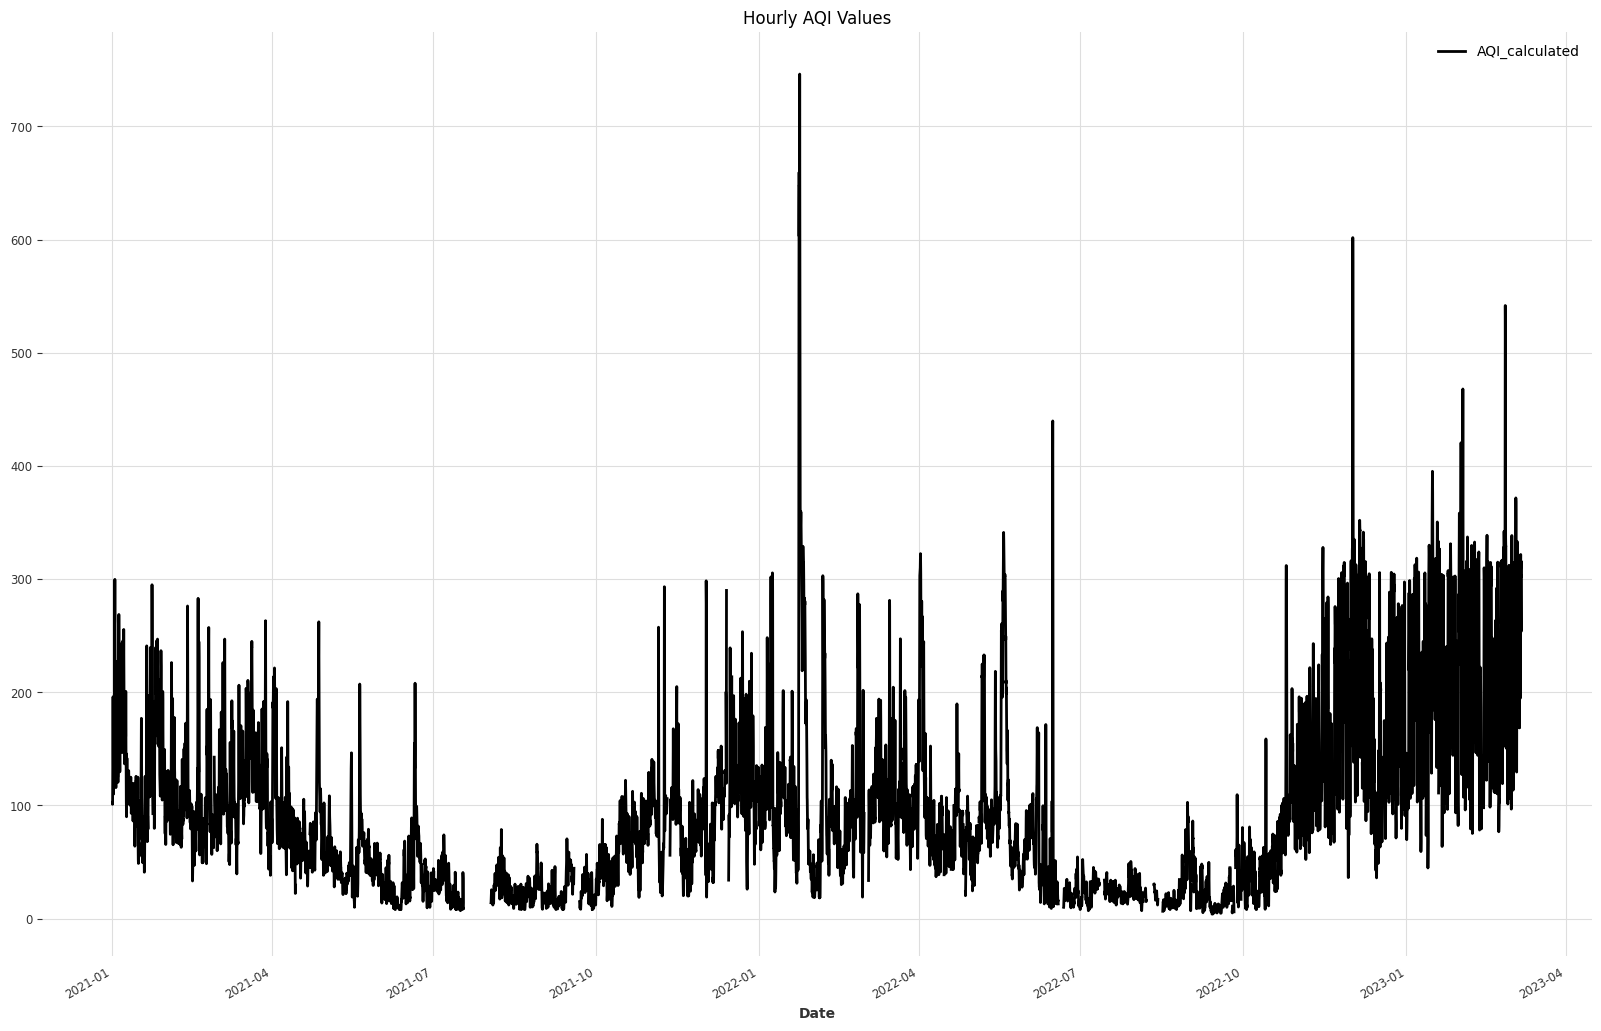

In [39]:
ts_aqi.plot()
plt.title('Hourly AQI Values')

Text(0.5, 1.0, 'Hourly AQI after Filling Missing Values')

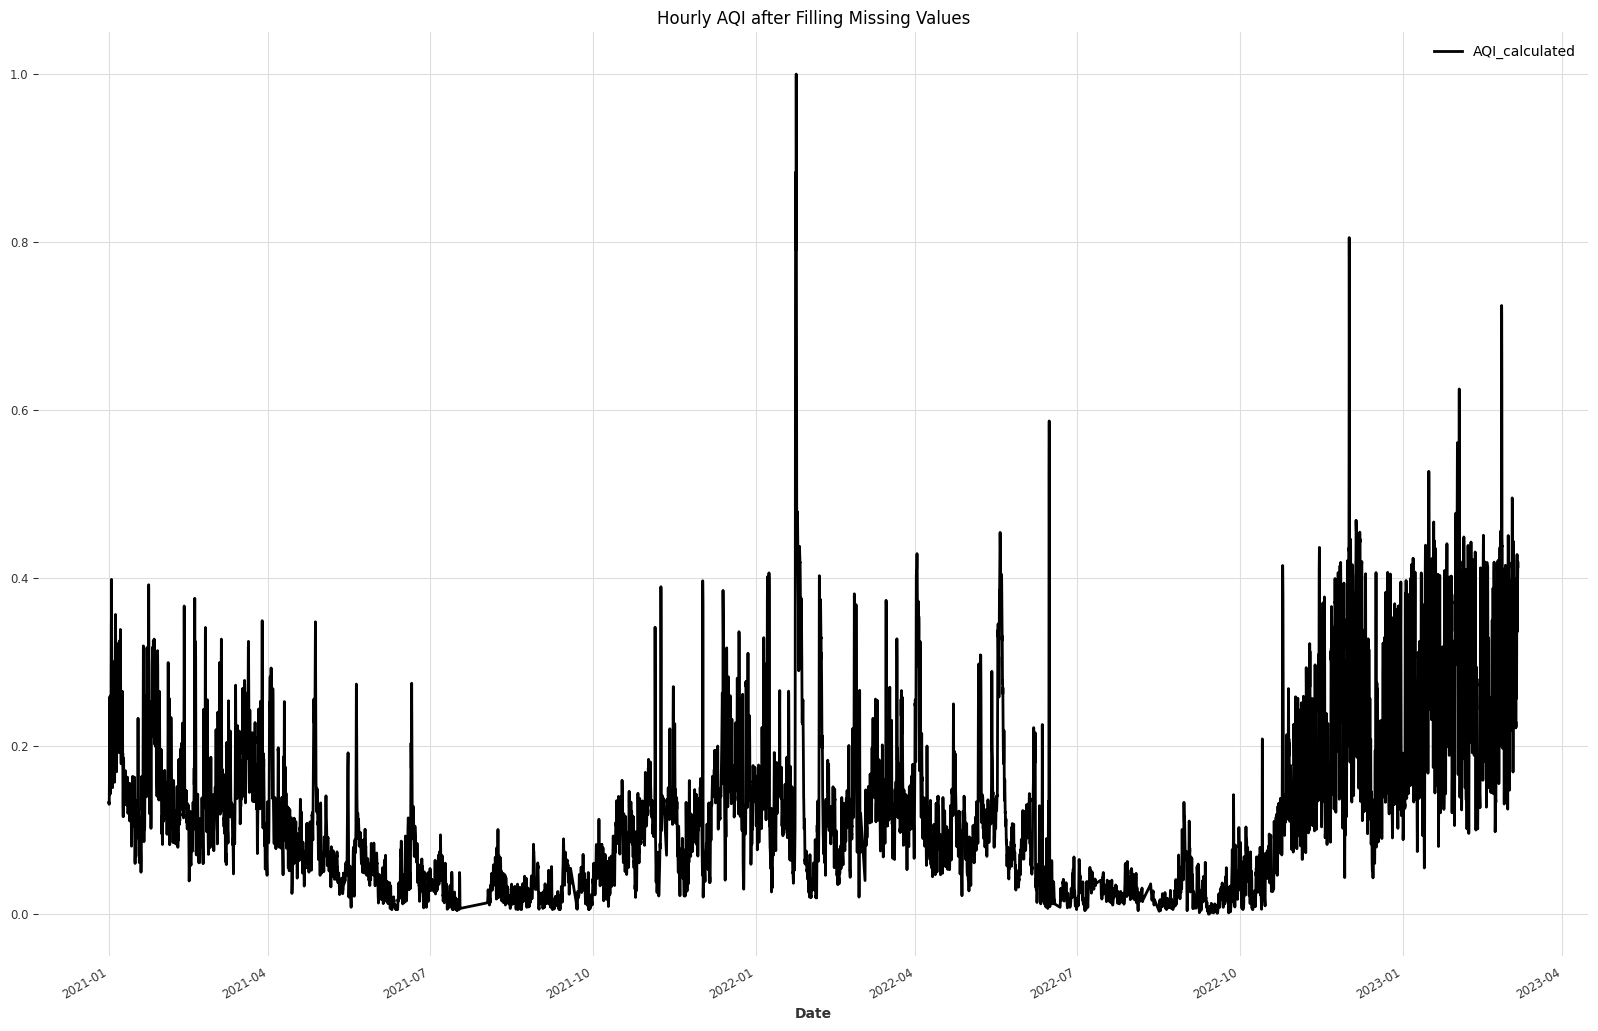

In [40]:
#Filling the Missing Values:

filler = MissingValuesFiller()
scaler = Scaler()


series = scaler.fit_transform(filler.transform(ts_aqi)).astype(np.float32)
series.plot()
plt.title("Hourly AQI after Filling Missing Values")

In [41]:
#Function to display the time series plot and summary statistics:

def display_forecast(pred_series,val_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(15, 10))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=(forecast_type + " forecasts"))
    plt.title(f"Mean Absolute Percentage Error = {(mape(val_series, pred_series).round(2))}%")
    plt.legend()

## Adding Co-variates:

In [42]:
df_hourly.columns

Index(['Date', 'Unnamed: 0', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2',
       'CO', 'Ozone', 'Benzene', 'Toluene', 'Eth-Benzene', 'MP-Xylene', 'RH',
       'WS', 'WD', 'BP', 'Xylene', 'AT', 'RF', 'TOT-RF', 'PM10_24hr_avg',
       'PM2.5_24hr_avg', 'SO2_24hr_avg', 'NOx_24hr_avg', 'NH3_24hr_avg',
       'CO_8hr_max', 'Ozone_8hr_max', 'PM2.5_SubIndex', 'PM10_SubIndex',
       'SO2_SubIndex', 'NOx_SubIndex', 'NH3_SubIndex', 'Checks',
       'AQI_calculated'],
      dtype='object')

In [43]:
ts_pm25 = TimeSeries.from_dataframe(df_hourly, "Date", "PM2.5")
ts_pm10 = TimeSeries.from_dataframe(df_hourly, "Date", "PM10")
ts_no2 = TimeSeries.from_dataframe(df_hourly, "Date", "NO2")
ts_so2 = TimeSeries.from_dataframe(df_hourly, "Date", "SO2")
ts_co = TimeSeries.from_dataframe(df_hourly, "Date", "CO")
ts_ozone = TimeSeries.from_dataframe(df_hourly, "Date", "Ozone")

In [44]:
ts_pm25 = fill_missing_values(ts_pm25)
ts_pm10 = fill_missing_values(ts_pm10)
ts_no2 = fill_missing_values(ts_no2)
ts_so2 = fill_missing_values(ts_so2)
ts_co = fill_missing_values(ts_co)
ts_ozone = fill_missing_values(ts_ozone)

## AQI FORECASTING :

In [45]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [46]:
#split the data:
training_cutoff = pd.Timestamp("20221001")
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create covariate series
covariates = ts_pm25.stack(ts_pm10).stack(ts_no2).stack(ts_so2).stack(ts_co).stack(ts_ozone)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [47]:
# default quantiles for QuantileRegression

quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]


input_chunk_length = 24
forecast_horizon = 12

In [ ]:
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=32,
    n_epochs=10,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)

In [ ]:
my_model.fit(train_transformed, future_covariates=covariates_transformed,epochs=5, verbose=True)

Training: 0it [00:00, ?it/s]

**Let us check the Error of the Base Model using Mean Absolute Percentage Error**

Predicting: 0it [00:00, ?it/s]

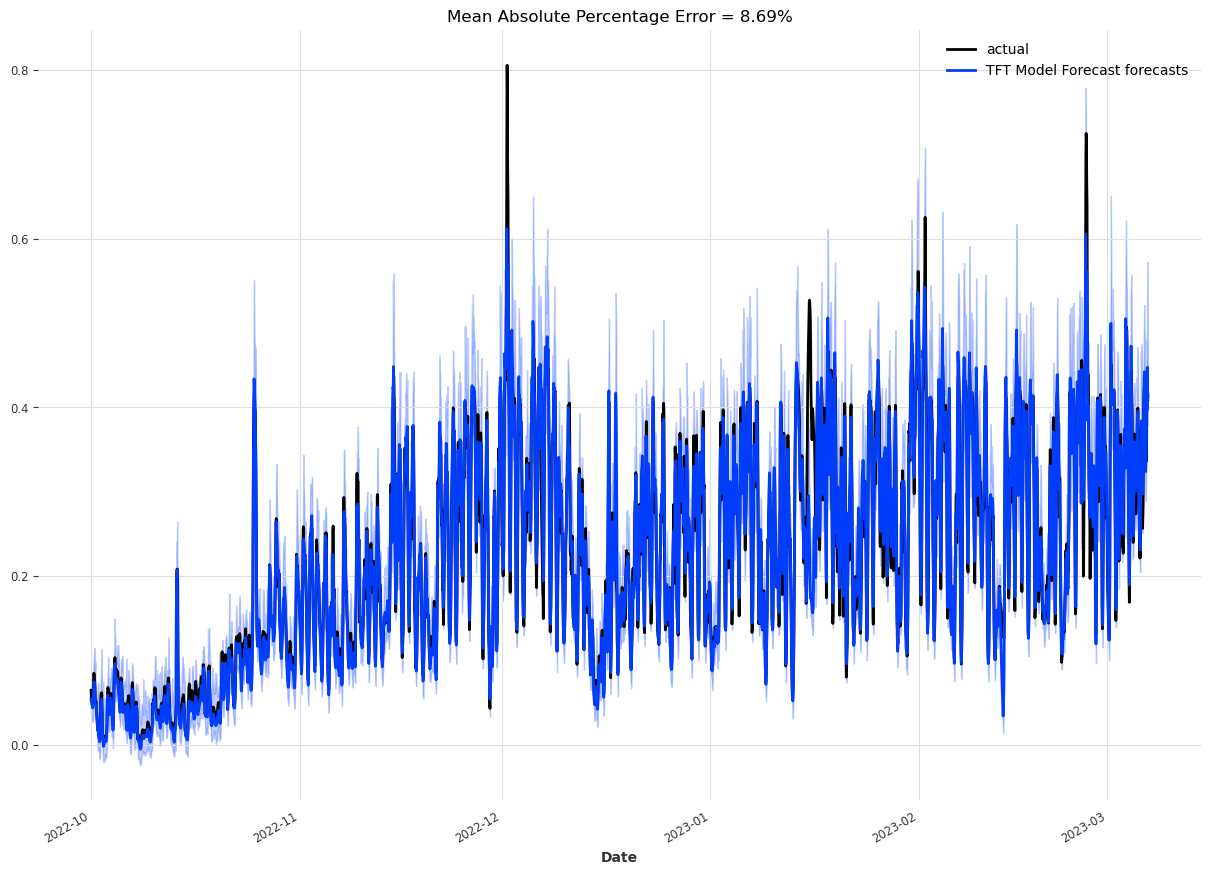

In [ ]:
my_model_forcast = my_model.predict(n=len(val_transformed), num_samples=num_samples)

display_forecast(my_model_forcast,val_transformed, series_transformed, "TFT Model Forecast", start_date=pd.Timestamp("20221001"))

## Hyperparameter Tuning :

### 1.Finding the Best Hidden Size

Hidden state size of the TFT. It is the main hyper-parameter and common across the internal TFT architecture

In [ ]:
def make_model(hidden_size):
    model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=hidden_size,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=5,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,)
    
    return model


def eval_model(model):
    model.fit(train_transformed, future_covariates=covariates_transformed,epochs=5, verbose=True)
    forecast = model.predict(n=len(val_transformed), num_samples=num_samples)
    print(f"model with Hidden Size {hs} obtains MAPE: {mape(val_transformed, forecast).round(2)}")
    
    
for hs in [32,64,128]:
    print(f"Hidden Size = {hs}")
    
    model_hs = make_model(hidden_size=hs)
    eval_model(model_hs)
    
    print()
    print()

Hidden Size = 32


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

model with Hidden Size 32 obtains MAPE: 6.52


Hidden Size = 64


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

model with Hidden Size 64 obtains MAPE: 7.08


Hidden Size = 128


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

model with Hidden Size 128 obtains MAPE: 7.28




## Dropout :

Fraction of neurons affected by dropout. This is compatible with Monte Carlo dropout at inference time for model uncertainty estimation

In [ ]:
def make_model_dropout(dropout):
    model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=128,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=dropout,
    batch_size=16,
    n_epochs=5,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,)
    
    return model


def eval_model_dropout(model):
    model.fit(train_transformed, future_covariates=covariates_transformed,epochs=5, verbose=True)
    forecast = model.predict(n=len(val_transformed), num_samples=num_samples)
    print(f"Model with Dropout {d} obtains MAPE: {mape(val_transformed, forecast).round(2)}")
    
    
for d in [0.0,0.1,0.2]:
    print(f"Dropout = {d}")
    
    model_dropout = make_model_dropout(dropout=d)
    eval_model_dropout(model_dropout)
    
    print()
    print()

Dropout = 0.0


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Model with Dropout 0.0 obtains MAPE: 7.5


Dropout = 0.1


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Model with Dropout 0.1 obtains MAPE: 7.28


Dropout = 0.2


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Model with Dropout 0.2 obtains MAPE: 11.11




## Batch Size:

Number of time series (input and output sequences) used in each training pass.

In [ ]:
def make_model_batch_size(batch_size):
    model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=128,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=batch_size,
    n_epochs=5,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,)
    
    return model


def eval_model_batch_size(model):
    model.fit(train_transformed, future_covariates=covariates_transformed,epochs=5, verbose=True)
    forecast = model.predict(n=len(val_transformed), num_samples=num_samples)
    print(f"Model with batch_size {bs} obtains MAPE: {mape(val_transformed, forecast).round(2)}")
    
    
for bs in [16,32,64]:
    print(f"batch_size = {bs}")
    
    model_batch_size = make_model_batch_size(batch_size=bs)
    eval_model_batch_size(model_batch_size)
    
    print()
    print()

batch_size = 16


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Model with batch_size 16 obtains MAPE: 7.28


batch_size = 32


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Model with batch_size 32 obtains MAPE: 6.85


batch_size = 64


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Model with batch_size 64 obtains MAPE: 8.07




## Learning Rate :

In [ ]:
def make_model_learning_rate(learning_rate):
    model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=128,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=5,
    add_relative_index=False,
    add_encoders=None,
    optimizer_kwargs={'lr': learning_rate},
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,)
    
    return model


def eval_model_learning_rate(model):
    model.fit(train_transformed, future_covariates=covariates_transformed,epochs=5, verbose=True)
    forecast = model.predict(n=len(val_transformed), num_samples=num_samples)
    print(f"Model with learning_rate {lr} obtains MAPE: {mape(val_transformed, forecast).round(2)}")
    
    
for lr in [1e-1,1e-2,1e-3]:
    print(f"learning_rate = {lr}")
    
    model_learning_rate = make_model_learning_rate(learning_rate=lr)
    eval_model_learning_rate(model_learning_rate)
    
    print()
    print()

learning_rate = 0.1


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Model with learning_rate 0.1 obtains MAPE: 79.51


learning_rate = 0.01


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Model with learning_rate 0.01 obtains MAPE: 7.64


learning_rate = 0.001


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Model with learning_rate 0.001 obtains MAPE: 7.28




## Training a LARGER MODEL :

Let's train a Model with updated parameters and higher epochs

In [48]:
tft_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=32,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=32,
    n_epochs=100,
    add_relative_index=False,
    add_encoders=None,
    optimizer_kwargs={'lr': 1e-3},
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)

In [49]:
tft_model.fit(train_transformed, future_covariates=covariates_transformed,epochs=100, verbose=True)

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

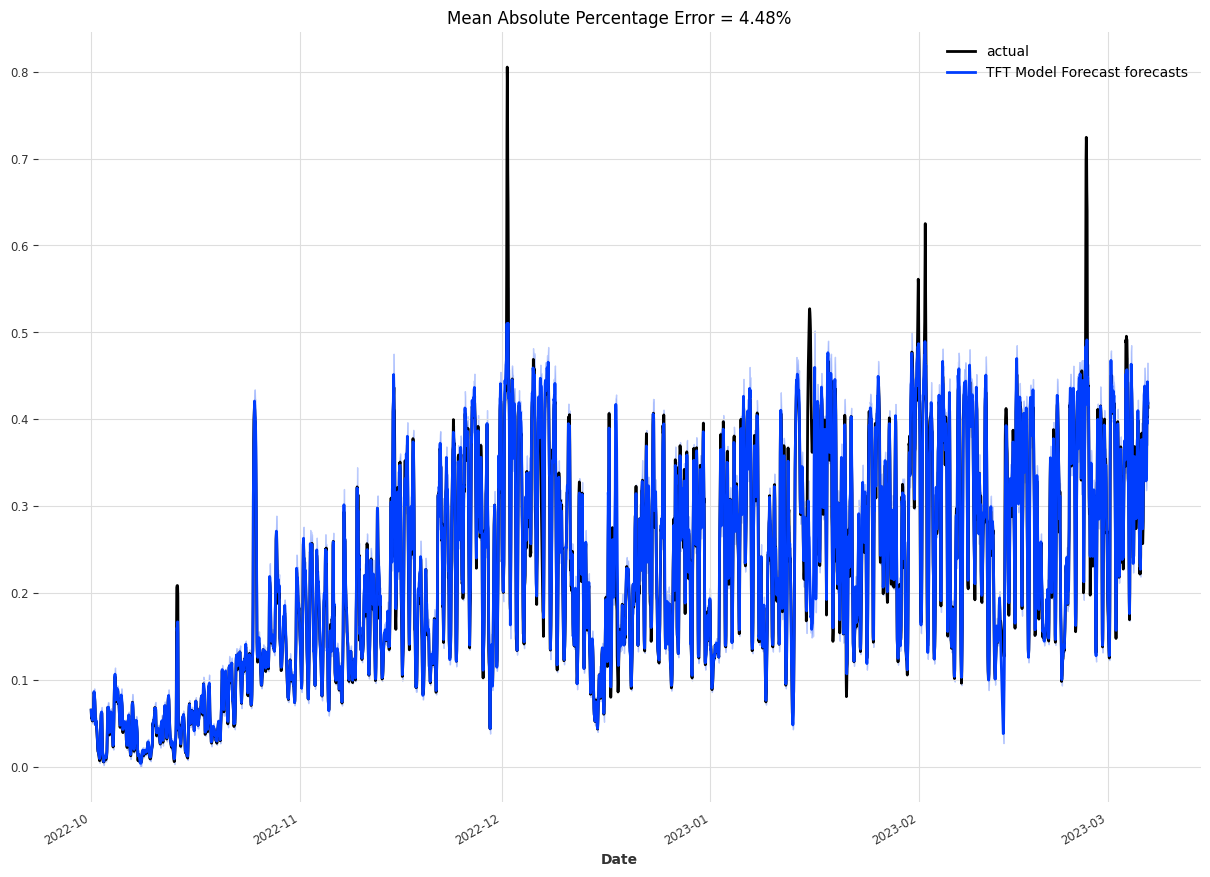

In [50]:
tft_model_forcast = tft_model.predict(n=len(val_transformed), num_samples=num_samples)

display_forecast(tft_model_forcast,val_transformed, series_transformed, "TFT Model Forecast", start_date=pd.Timestamp("20221001"))

#### Saving the Model :

In [54]:
tft_model.save('tft_model')

In [51]:
import pickle
  
# Save the trained model as a pickle string.
saved_model = pickle.dumps(tft_model)

In [52]:
# Load the pickled model
tft_model_from_pickle = pickle.loads(saved_model)

In [70]:
# Use the loaded pickled model to make predictions

prediction = tft_model.predict(n=10*forecast_horizon, num_samples=num_samples)
prediction

Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (Date: 120, component: 1, sample: 200)>
array([[[0.06675012, 0.06696278, 0.06675628, ..., 0.06574117,
         0.06636678, 0.06654081]],

       [[0.05699463, 0.05950012, 0.05766961, ..., 0.05647131,
         0.0569375 , 0.05507386]],

       [[0.06146501, 0.0530594 , 0.05523521, ..., 0.05664025,
         0.05748339, 0.05848586]],

       ...,

       [[0.04220229, 0.04553724, 0.04731032, ..., 0.04593838,
         0.04546671, 0.04624278]],

       [[0.04016528, 0.05001721, 0.04954134, ..., 0.04695283,
         0.04713725, 0.04422249]],

       [[0.04875434, 0.05036839, 0.05179768, ..., 0.05223883,
         0.05144724, 0.05356752]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 2022-10-01T01:00:00 ... 2022-10-06
  * component  (component) object 'AQI_calculated'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [71]:
aqi_predicted = scaler.inverse_transform(prediction)

Text(0.5, 1.0, 'Predictions')

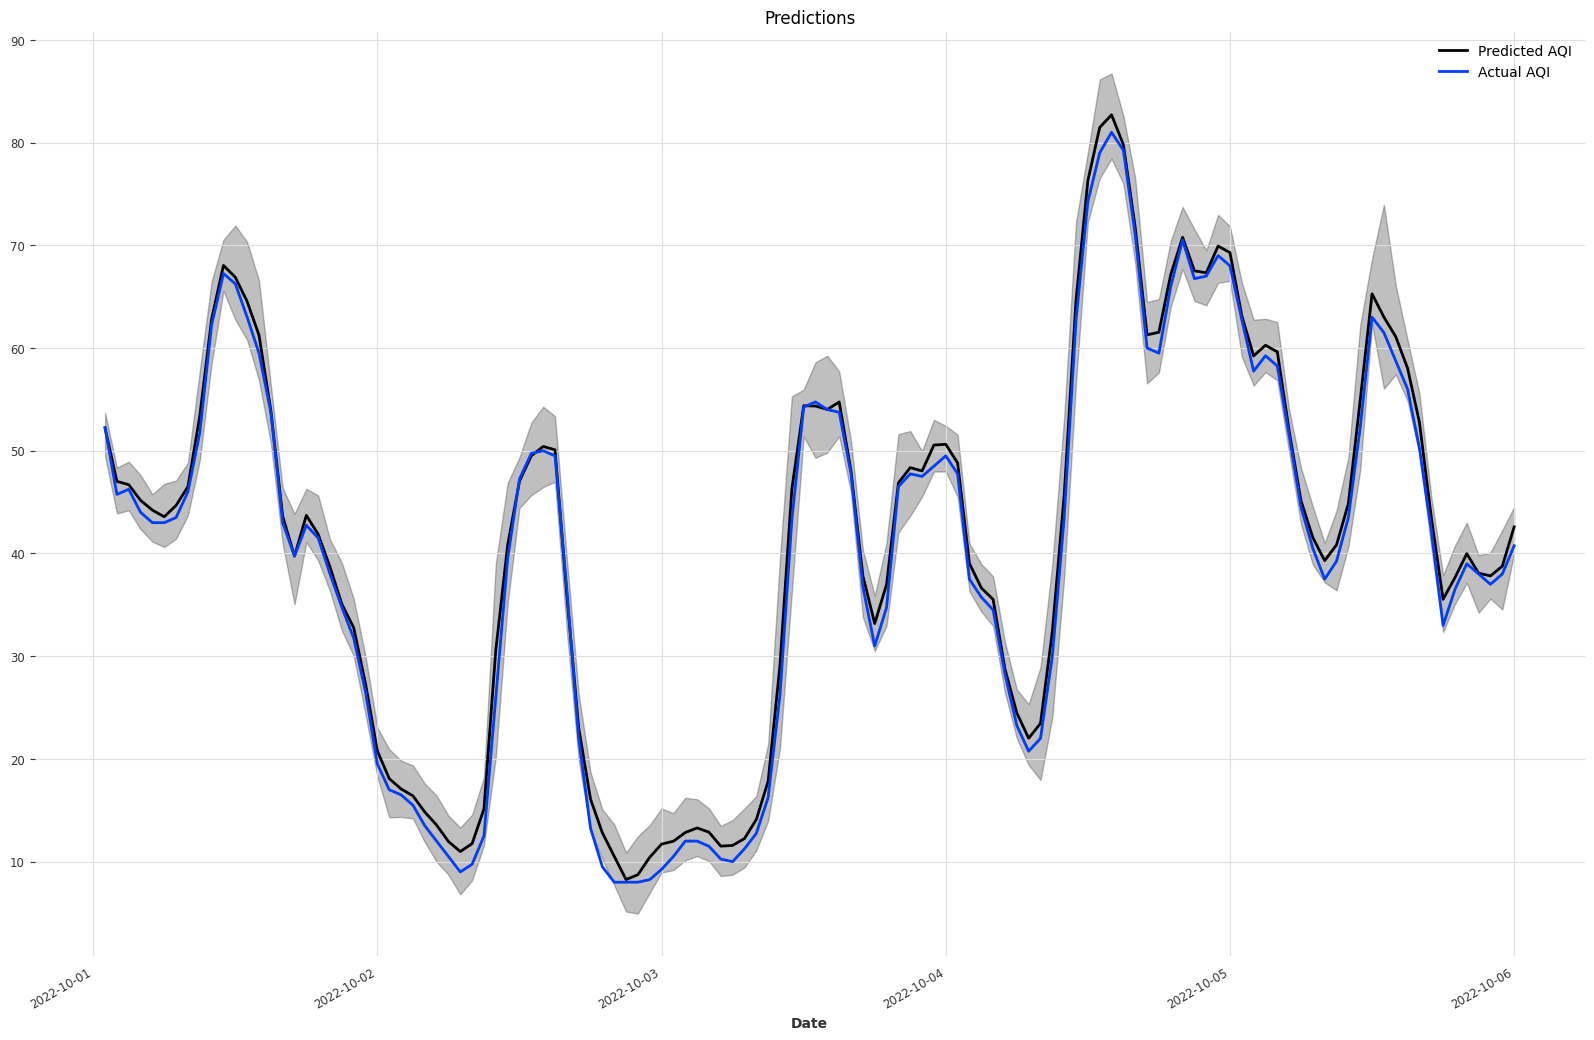

In [72]:
aqi_predicted.plot(label='Predicted AQI')
ts_aqi[len(train_transformed):len(train_transformed)+10*forecast_horizon].plot(label='Actual AQI')
plt.title("Predictions")